In [9]:
from fastai.vision.all import *
from fastai.vision.widgets import *

PATH = Path('/home/rory/Dropbox/Photos/mushrooms')
IMS = PATH/'ims/mo'
MODELS = PATH/'models'

trained_model_fn = 'learner_20211027-4.pth'

# Dataloaders

Our items are the images in `IMS`.

In [2]:
ims = IMS.ls()

ims[0]

Path('/home/rory/Dropbox/Photos/mushrooms/ims/mo/718379.jpg')

We use the annos df to build our getters.

In [3]:
df = pd.read_csv(PATH/'mo_annos_filtered.csv', sep='\t')

df.head(3)

Unnamed: 0                                             link   id  \
0          12   https://mushroomobserver.org/images/640/67.jpg   67   
1          13   https://mushroomobserver.org/images/640/68.jpg   68   
2          49  https://mushroomobserver.org/images/640/315.jpg  315   

              mushroom     created   photographer  
0  Trametes versicolor  2002-01-08  Nathan Wilson  
1  Trametes versicolor  2002-01-08  Nathan Wilson  
2    Lactarius rubidus  2002-01-09  Nathan Wilson

We'll combine the `id` and `mushroom` columns in the df to create `fn2lbl`, then use `fn2lbl` to make `get_y`.

In [4]:
fn2lbl = {str(i) + '.jpg' : m for i,m in list(zip(df['id'], df['mushroom']))}

fn2lbl[ims[42].name]

'Mycena pura'

In [5]:
def get_y(path): return fn2lbl[path.name]

get_y(ims[42])

'Mycena pura'

The `ims` list contains images that haven't been deleted. The deleted images are in `PATH/deleted_images`. So, we make sure every record in the df is one that hasn't been deleted.

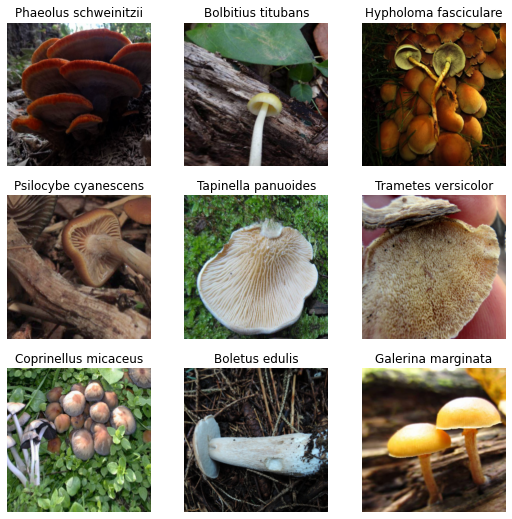

In [6]:
db = DataBlock(
    blocks     = (ImageBlock, CategoryBlock),
    get_y      = get_y,
    splitter   = RandomSplitter(valid_pct=0.2),
    item_tfms  = RandomResizedCrop(400, min_scale=0.75),
    batch_tfms = aug_transforms(size=256))
    
dls = db.dataloaders(ims)
dls.show_batch()

# Learner

In [7]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

In [8]:
learn.fine_tune(10, 3e-3)

In [15]:
# learn.export(MODELS/trained_model_fn)

# Interp

('Galerina marginata', 'Psilocybe cyanescens', 8)
('Agaricus hondensis', 'Agaricus xanthodermus', 6)
('Stereum hirsutum', 'Trametes versicolor', 6)
('Chlorophyllum brunneum', 'Chlorophyllum molybdites', 5)
('Coprinopsis atramentaria', 'Coprinellus micaceus', 5)
('Lactarius xanthogalactus', 'Lactarius alnicola', 5)
('Leratiomyces ceres', 'Psilocybe cyanescens', 5)
('Phaeolus schweinitzii', 'Trametes versicolor', 5)
('Trametes versicolor', 'Stereum hirsutum', 5)
('Agaricus xanthodermus', 'Agaricus hondensis', 4)


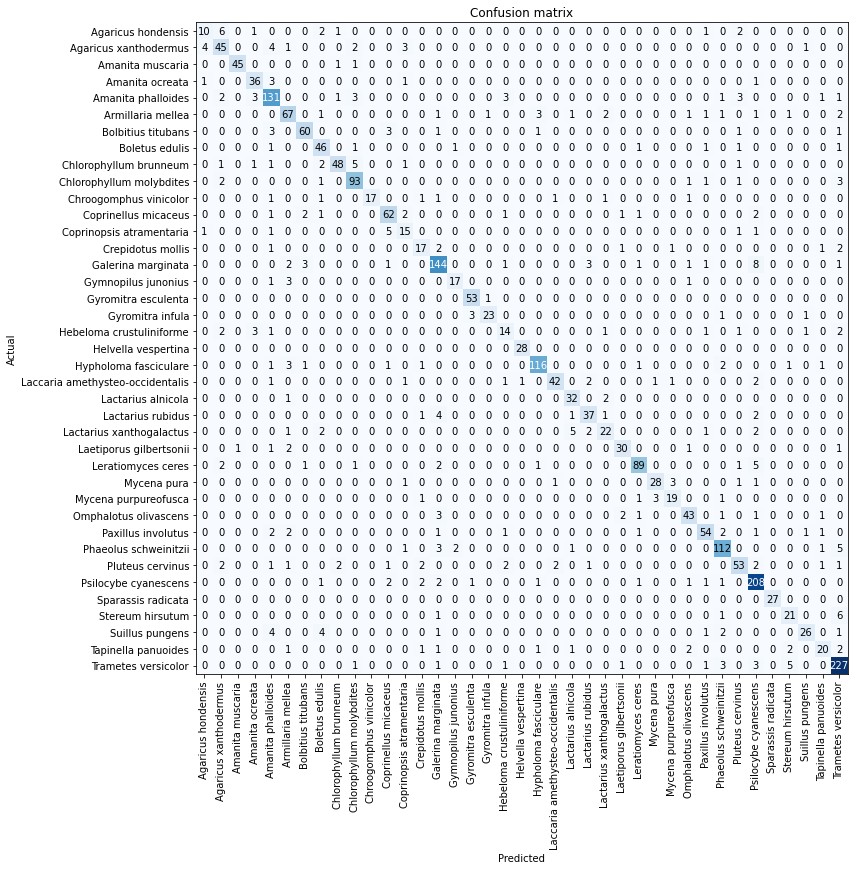

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

print(*interp.most_confused()[:10], sep='\n')

interp.plot_confusion_matrix(figsize=(12,12))

Are there still obviously bad images?

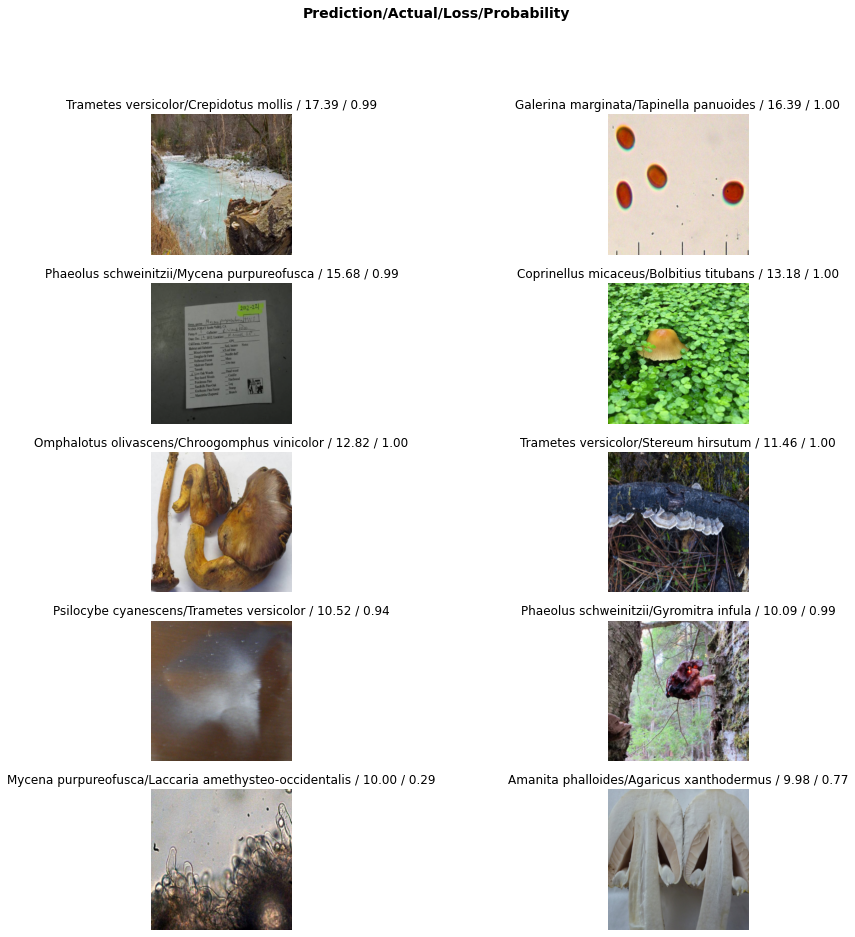

In [22]:
interp.plot_top_losses(10, nrows=5, figsize=(15,15))

# Cleaner

In [13]:
# learn.dls = db.dataloaders(IMS.ls())
cleaner = ImageClassifierCleaner(learn, height=200, width=400, max_n=50)
cleaner

In [27]:
for idx in cleaner.delete():
    
    p = cleaner.fns[idx]
    
    try:
        shutil.move(str(p), PATH/'ims/dirty'/p.name)
        print("moved to dirty:", p)
        
    except:
        print("couldn't find", p, "in images (likely already removed)")

moved to dirty: /home/rory/Dropbox/Photos/mushrooms/ims/mo/107357.jpg
moved to dirty: /home/rory/Dropbox/Photos/mushrooms/ims/mo/705161.jpg
moved to dirty: /home/rory/Dropbox/Photos/mushrooms/ims/mo/1174793.jpg
moved to dirty: /home/rory/Dropbox/Photos/mushrooms/ims/mo/1240012.jpg
moved to dirty: /home/rory/Dropbox/Photos/mushrooms/ims/mo/86528.jpg
moved to dirty: /home/rory/Dropbox/Photos/mushrooms/ims/mo/556568.jpg
moved to dirty: /home/rory/Dropbox/Photos/mushrooms/ims/mo/86526.jpg
moved to dirty: /home/rory/Dropbox/Photos/mushrooms/ims/mo/291629.jpg
moved to dirty: /home/rory/Dropbox/Photos/mushrooms/ims/mo/418595.jpg
moved to dirty: /home/rory/Dropbox/Photos/mushrooms/ims/mo/82182.jpg
moved to dirty: /home/rory/Dropbox/Photos/mushrooms/ims/mo/556574.jpg
moved to dirty: /home/rory/Dropbox/Photos/mushrooms/ims/mo/557360.jpg
moved to dirty: /home/rory/Dropbox/Photos/mushrooms/ims/mo/28748.jpg
moved to dirty: /home/rory/Dropbox/Photos/mushrooms/ims/mo/556573.jpg


If the cleaner breaks, try rerunning it with a fresh dls that omits the removed images (do this by removing the comment in the first line of code in this section).

# Inference

I'll now test the trained model on pictures I took. They're located in the `ims/infer` folder.

In [28]:
trained_model = load_learner(MODELS/trained_model_fn)

In [29]:
user_ims = (PATH/'ims/infer').ls()
user_ims

(#5) [Path('/home/rory/Dropbox/Photos/mushrooms/ims/infer/Suillus2.jpeg'),Path('/home/rory/Dropbox/Photos/mushrooms/ims/infer/IMG_6721.jpg'),Path('/home/rory/Dropbox/Photos/mushrooms/ims/infer/suillus.jpeg'),Path('/home/rory/Dropbox/Photos/mushrooms/ims/infer/IMG_6734.jpg'),Path('/home/rory/Dropbox/Photos/mushrooms/ims/infer/IMG_6742.jpg')]

Prediction: Suillus pungens | Conf: 99%


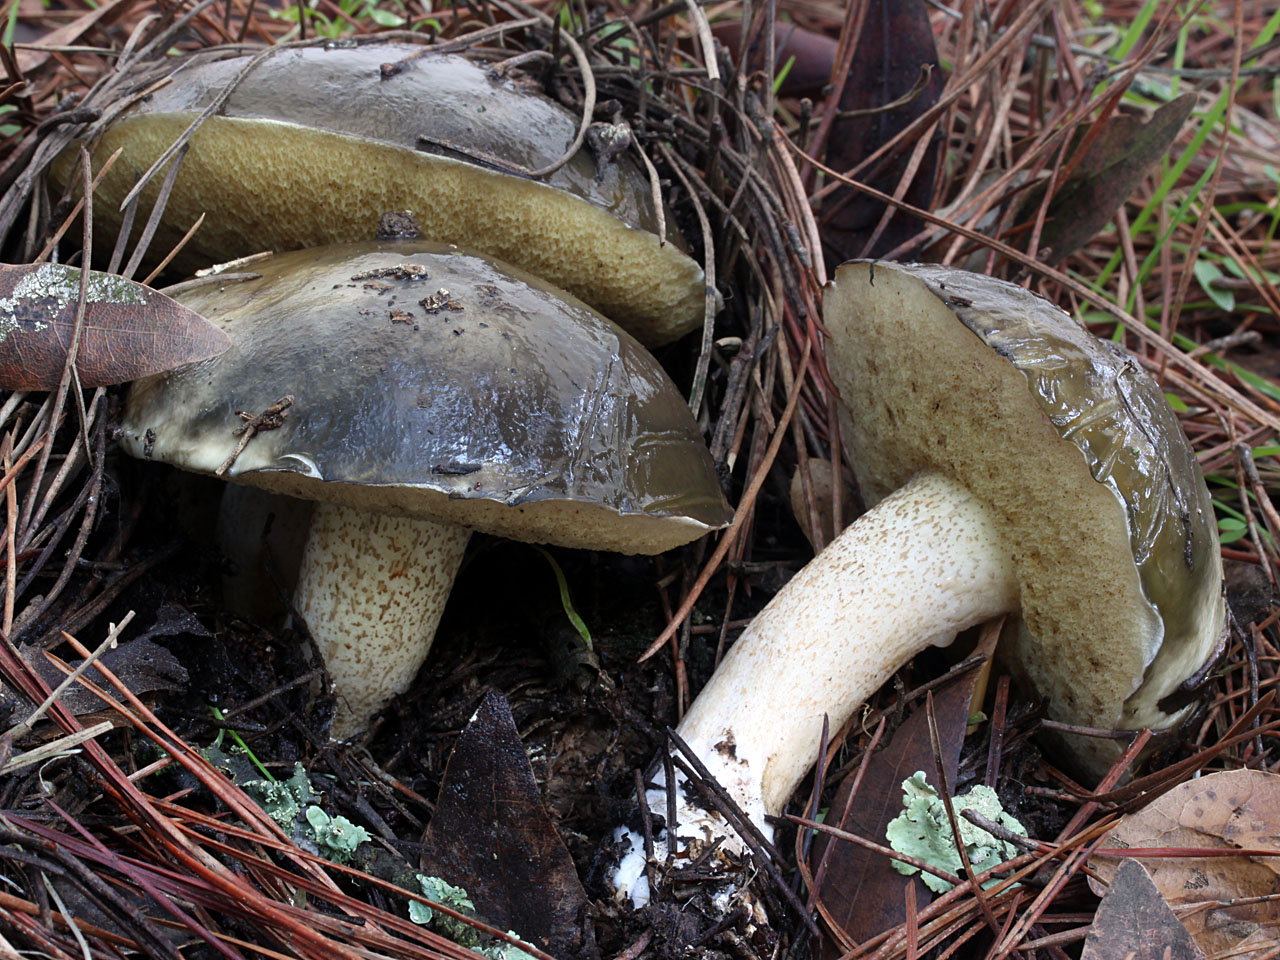

In [30]:
idx = 0

im = PILImage.create(user_ims[idx])
preds = trained_model.predict(user_ims[idx])

print(f'Prediction: {preds[0]} | Conf: {int(100*preds[2][preds[1]])}%'); im

Prediction: Boletus edulis | Conf: 67%


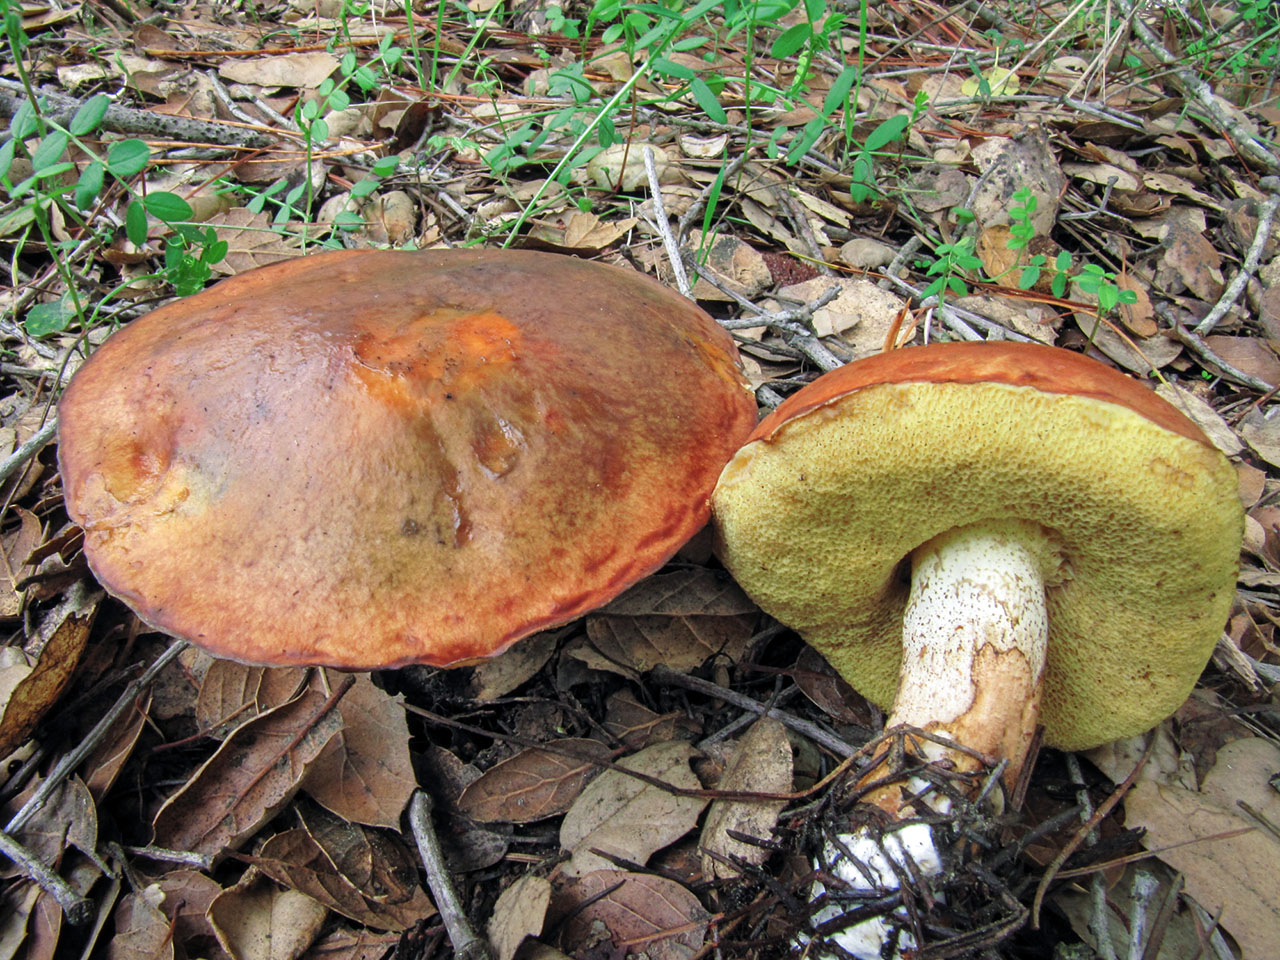

In [31]:
idx = 2

im = PILImage.create(user_ims[idx])
preds = trained_model.predict(user_ims[idx])

print(f'Prediction: {preds[0]} | Conf: {int(100*preds[2][preds[1]])}%'); im